# DMC Example: Forces for the Infinite Elliptical Well in 2D

This example shows how to use DMC for a 2D single-particle example, namely, the elliptical box. This is modeled by the Hamiltonian

$$
    H = -\frac{1}{2}\nabla^2
$$

for $x \in \mathcal{E}$, with $\mathcal{E}$ an ellipse centered at the origin with foci at $x_1 = \pm a$. The exact ground state wave function is

$$
    \Psi_0 = \mathrm{Ce}_0(\mu, q_{00})\mathrm{ce}_0(\nu, q_{00}),
$$

with $q_{00} = 0.8253525490491695$, $\mathrm{Ce}_m$ the modified cosine-extended Mathieu function of order $m$, and $\mathrm{ce}_n$ the cosine-extended Mathieu function of order $n$. The parameter $q_{mn}$ is quantized due to the homogeneous Dirichlet boundary condition at $\partial \mathcal{E}$; it determines the energy via

$$
    E_{mn} = 2q_{mn}/a^2.
$$

Thus, the exact ground state energy is $E_{00} = 1.65071$.

We wish to use DMC to estimate the "force"

$$
    F = -\frac{\partial E}{\partial a},
$$

which can be done using the formula

$$
    F = -\left\langle \frac{\partial E_L}{\partial a} + (E_L - E) \frac{\partial}{\partial a}\ln(\pi) \right\rangle,
$$

where $\pi$ indicates the mixed distribution, $\pi(x) = \Phi(x)\Psi_G(x)$, with $\Psi_G$ the guiding wave function. In VMC, the same formula can be used, but instead one uses for $\pi$ the variational distribution $\pi(x) = \Psi_G(x)^2$. In this simple example, one can evaluate the force exactly by using trapezoidal integration, from which we find $F = 7.35205$.

## Set up a DMC Run

We proceed to set up a DMC simulation of the elliptical well:

In [5]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [31]:
q0 = 0.8253525490491695
a0 = 1
nconf = 100
time_step = 1e-3
#reference_energy = 3.67603
reference_energy =  3.92097
blocks = 100
steps_per_block = 10
hamiltonian = lambda psi, x: -0.5*psi.laplacian(x)

As a trial wave function, we use something with the same nodes at the boundary of the ellipse as the analytical ground state. Previously, we used $\Psi_G = x\Psi_0(x, y)$, but this wave function is already very close to the fixed-node solution. To be able to actually see some improvement with DMC, we choose instead

$$
    \Psi_G(x, y) = x\left(\frac{r + 1}{2}\right)\left(1 - \frac{r + 2}{2}\right),
$$

where $r^2 = x^2/\alpha^2 + y^2/\beta^2$, $\alpha = a\cosh(1)$, $\beta = a\sinh(1)$. This wave function has a variational energy of

$$
    E_V = 3.92097,
$$

which is what we take for the DMC reference energy.

In [32]:
import scipy.special as spec

def mathieu_modcem1(m, q, x):
    return spec.mathieu_modcem1(m, q, x)

def mathieu_cem(m, q, x):
    # Angular mathieu function in scipy takes input
    # in degrees
    return spec.mathieu_cem(m, q, x*180/np.pi)

def ground_state(mu, nu):
    return mathieu_modcem1(0, q0, mu)[0]*mathieu_cem(0, q0, nu)[0]

class GuidingWaveFunction(WaveFunction):

    def __init__(self, a):
        self._a = a

    def __call__(self, x):
        x, y = x
        alpha = self._a*np.cosh(1)
        beta = self._a*np.sinh(1)
        r = np.sqrt((x/alpha)**2 + (y/beta)**2)
        return x*(r + 1)/2 * (1 - (r+1)/2)
        #mu = np.real(np.arccosh((x + 1j*y)/self._a))
        #nu = np.imag(np.arccosh((x + 1j*y)/self._a))
        #return x*ground_state(mu, nu)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

In [33]:
brancher = SRBrancher()
#brancher = SimpleBrancher()
ar = DiffuseAcceptReject(fixed_node=True)
guiding_wf = GuidingWaveFunction(a0)

In [34]:
np.random.seed(0)

nu_rand = np.random.uniform(0, 2*np.pi)
x0 = np.array([a0*np.cosh(1)*np.cos(nu_rand), a0*np.sinh(1)*np.sin(nu_rand)], dtype=object)
norm = guiding_wf.gradient(x0) / np.linalg.norm(guiding_wf.gradient(x0))
eps = 1e-1
xstart = x0 + eps * norm

#confs = [copy.deepcopy(xstart) for _ in range(nconf)]
confs = [np.random.uniform(low=-1, high=1, size=2) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

Since in DMC, we do not have direct access to the distribution $\pi(x)$, we cannot use the same expression used for the forces in VMC. Instead, we use the VD approximation, wherein the forces are calculated as

$$
    F = -\left\langle
        \nabla_a E_L + [E_L - E]\left(
            \nabla_a \ln \Psi_G^2 + \sum_n \nabla_a S(x_{n+1}, x_n)
        \right)
    \right\rangle,
$$

where $S(x_{n+1}, x_n) = \tau\left(E_T - \frac{1}{2}(E_L(x_{n+1} + E_L(x_n))\right)$, and the sum runs over all equilibrated configurations. In the code below, this expression is evaluated using finite differences. To do this, we accumulate samples for both a primary and a secondary geometry, where the ellipse is stretched by displacing the foci by $\Delta a$ in either direction.

In [35]:
dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)

# set up secondary geometry wave function
da = 1e-3
psi_sec = GuidingWaveFunction(a0 + da)

# add accumulator
accum = Accumulator({
    "local energy": lambda psi, x: hamiltonian(psi, x) / psi(x),
    "local energy secondary": lambda _, x: hamiltonian(psi_sec, x) / psi_sec(x),
    "wave function": lambda psi, x: psi(x),
    "wave function secondary": lambda _, x: psi_sec(x)
})

accum = dmc.run_dmc(time_step, blocks, steps_per_block, accumulator=accum, neq=10)

Obtain the results for the DMC energy and its estimated error:

In [36]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"DMC Energy:   {energy:.5f} +/- {err:.5f}")
print(f"Variational:  {reference_energy:.5f}")
print(f"Exact:        {2*q0/a0**2:.5f}")
print(f"Acceptance:   {dmc.acceptance:.5f}")

DMC Energy:   3.58090 +/- 0.05050
Variational:  3.92097
Exact:        1.65071
Acceptance:   0.99878


See how the energy estimate evolved over time:

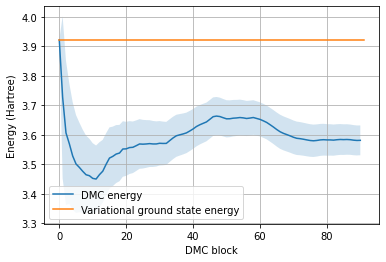

In [37]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, dmc.energy_estimate - dmc.energy_error, dmc.energy_estimate + dmc.energy_error, alpha=0.2)

exact = 2*q0/a0**2
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], label="Variational ground state energy")
#plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

Finally, we extract the data necessary to compute the force estimate:

In [38]:
psis = accum.observables_data["wave function"]
psis_sec = accum.observables_data["wave function secondary"]
eref = np.array(accum.ref_energy)

local_energies = np.array(accum.observables_data["local energy"])
local_energies_sec = np.array(accum.observables_data["local energy secondary"])

branching_factors = time_step * (eref[1:] - 0.5 * (local_energies[1:] - local_energies[:-1]))
branching_factors_sec = time_step * (eref[1:] - 0.5 * (local_energies_sec[1:] - local_energies_sec[:-1]))

In [39]:
# compute "local force"
local_energy_deriv = (local_energies_sec[1:] - local_energies[1:]) / da
psi_logderiv = (np.log(np.abs(psis_sec)) - np.log(np.abs(psis))) / da
branching_factor_deriv = (branching_factors_sec - branching_factors) / da

local_force = -(local_energy_deriv + (local_energies[1:] - energy) * (2*psi_logderiv[1:] + np.sum(branching_factor_deriv)))

# compute mean force
force = np.mean(local_force)
print(f"DMC Force: {force:.5f}")

DMC Force: 14.49020


Plot the data trace of the "local force" over time:

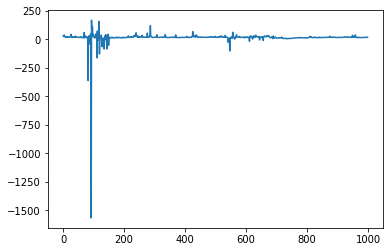

In [40]:
plt.plot(local_force)